In [1]:
import sys
sys.path.append("..")
import os
import json
import seaborn as sns
from collections import Counter
import openai
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
from games.ultimatum.ultimatum_multi_turn.game import MultiTurnUltimatumGame
import itertools
from collections import defaultdict
import os
import json
import openai
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from explorer.utils import load_states_from_dir
import matplotlib.pyplot as plt
import warnings
import pandas as pd
from pandas.errors import SettingWithCopyWarning
import seaborn as sns
import matplotlib.pyplot as plt
colormap = sns.color_palette("Blues") 
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
%env OPENAI_API_KEY="g"

2024-03-24 15:50:27.005 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


env: OPENAI_API_KEY="g"


In [2]:
def get_from_summary(key, game_state, default=None):
    if key in game_state.game_state[-1]['summary']:
        return game_state.game_state[-1]['summary'][key]
    else:
        return default

def replace_names(df):
    df_copy = df.copy()
    df_copy["model_1"] = df_copy["model_1"].replace(rename_dict)
    df_copy["model_2"] = df_copy["model_2"].replace(rename_dict)
    return df_copy
    
def get_player_valuation(game_state, default=None):
    if "player_valuation" in game_state.game_state[0]["settings"]:
        vals = game_state.game_state[0]["settings"]["player_valuation"]
        return vals
    else:
        return default
        
def compute_game_summary(game_states):

    game_name = np.array([g.__class__.__name__ for g in game_states])[:, None]
    models = np.array([[ p.model for p in g.players] for g in game_states])
    outcomes = np.array([get_from_summary('player_outcome', g) for g in game_states])
    valuations = np.array([get_player_valuation(g, default=[None,None])  for g in game_states])
    initial_resources = np.array([get_from_summary('initial_resources', g) for g in game_states])
    final_resources = np.array([get_from_summary('final_resources', g) for g in game_states]),
    resources_delta = (final_resources-initial_resources)[0]

    original_valuations = valuations.reshape(-1, 2)
        
    resources_delta = np.array([v.value(r) if v else r.value() for r,v in zip(resources_delta.reshape(-1,), valuations.reshape(-1))])
    resources_delta = resources_delta.reshape(-1, 2)

    social_behavior = np.array([g.player_social_behaviour for g in game_states])
    social_behavior = social_behavior.reshape(-1, 2)

    initial_resources = initial_resources.reshape(-1, 2)
    
    
    df = np.concatenate((game_name, models, outcomes,  resources_delta, social_behavior, original_valuations, initial_resources), axis=1)
    df = pd.DataFrame(df, columns=['game_name','model_1','model_2','outcome_1','outcome_2', 'resource_delta_1', 'resource_delta_2', "social_1", "social_2", "vals1", "vals2", "init1", "init2"])

    return replace_names(df)


def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)


def normalize_win_rate(loc):
    "transform_win_rates_of_local_aggregate_into_probs_ingoring_draws"

    seen = set()

    l = loc.copy()
    
    for first in l.columns:
        for second in l.columns:
            if first!=second and first+second not in seen:
                one = l[first][second]
                two = l[second][first] 
    
                l[first][second], l[second][first] = one/(one+two), two/(one+two)

    return l
            

In [3]:
AGENTS = ["gpt-4-1106-preview", "claude-2.1", "claude-2", "gpt-3.5-turbo-1106",]
AGENTS_CLEAN_NAMES = ["GPT-4", "Claude-2.1", "Claude-2", "GPT-3.5"]
rename_dict = {k:v for k,v in zip(AGENTS, AGENTS_CLEAN_NAMES)}



In [4]:
log_dir = "../experiments/rebuttal/.logs/ultimatum_with_different_numbers_claude"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 



2024-03-24 15:51:25.596 
  command:

    streamlit run /home/vinid/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-03-24 15:51:25.597 No runtime found, using MemoryCacheStorageManager



Exception Type: AssertionError
Exception Message: WARNING : Game  ../experiments/rebuttal/.logs/ultimatum_with_different_numbers_claude/1711303642782/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/vinid/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_result
  

In [71]:
df = compute_game_summary(game_states)


In [75]:
df = compute_game_summary(game_states)

df["total_sum"] = df.apply(lambda x: x.outcome_1.resource_dict["Dollars"]+x.outcome_2.resource_dict["Dollars"],axis=1)
df = df[df["resource_delta_2"] != 0]


In [76]:

df["resource_delta_1"] = df["resource_delta_1"] + df["total_sum"]
df["resource_delta_1"] = (df["resource_delta_1"]/df["total_sum"]).apply(lambda x : round(x, 4))
df["resource_delta_2"] = (df["resource_delta_2"]/df["total_sum"]).apply(lambda x : round(x, 4))
df = df[df["resource_delta_1"] > 0]


In [77]:
mini_df = df.groupby("total_sum")[['resource_delta_1', 'resource_delta_2']].agg(["mean", "sem"])
mini_df = mini_df[mini_df.index.isin([100, 1000, 10000, 1000000, 100000000, 10000000000])]


In [78]:
mini_df = mini_df.reset_index()

In [79]:
mini_df.columns = ['Amount To Split', '% Left to P1', "SEM", 'resource_delta_2', "ignore"]

In [80]:
10,000,000,000

(10, 0, 0, 0)

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_palette('colorblind')

In [82]:
def fix_numbers(x):
    return "{:e}".format(int(x)).split(".")[0] +  "e" + "{:e}".format(int(x)).split("e")[1]

In [83]:
mini_df["Amount To Split"] = mini_df["Amount To Split"].astype(str).apply(fix_numbers)

In [87]:
mini_df

,Amount To Split,% Left to P1,SEM,resource_delta_2,ignore
0,1e+02,0.641000,0.035208,0.359000,0.035208
1,1e+03,0.808207,0.024364,0.191793,0.024364
2,1e+04,0.765333,0.023312,0.234667,0.023312
3,1e+06,0.816500,0.021843,0.183500,0.021843
4,1e+08,0.876103,0.030835,0.123900,0.030835
5,1e+10,0.899850,0.030089,0.100150,0.030089


/tmp/ipykernel_315160/2349267725.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(mini_df, x="Amount To Split", y="% Left to P1",


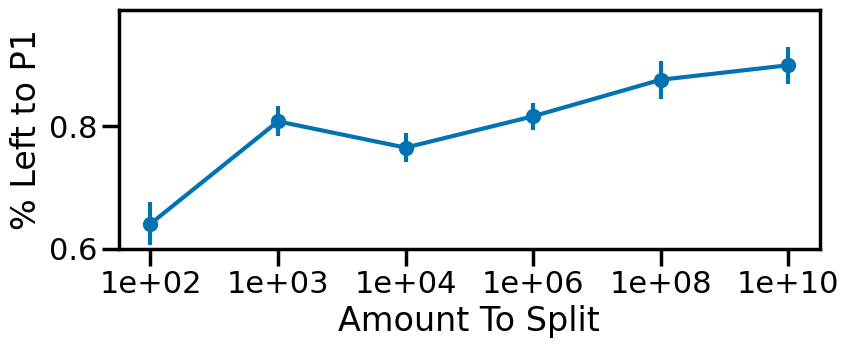

In [105]:
sns.set_context('poster')
fig, axs = plt.subplots(figsize=(9,4))
fig.tight_layout()

sns.scatterplot(mini_df, x="Amount To Split", y="% Left to P1", 
            palette=sns.color_palette(n_colors=len([3])), ax=axs)
fig.tight_layout()

axs.set_ylim(0.6, 0.99)

plt.errorbar(mini_df["Amount To Split"], mini_df["% Left to P1"], yerr=mini_df["SEM"])
 
plt.savefig('figures/section_three_ultimatum_scaling_rebuttal.pdf', bbox_inches='tight')
plt.show()

In [4]:
log_dir = "../experiments/additional_experiments/.logs/buysell_scaling/"
game_states = load_states_from_dir(log_dir) #+ load_states_from_dir(log_dir) 



2024-01-31 20:44:46.103 
  command:

    streamlit run /home/xxxx/.local/lib/python3.10/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-01-31 20:44:46.104 No runtime found, using MemoryCacheStorageManager



Exception Type: AssertionError
Exception Message: WARNING : Game  ../experiments/additional_experiments/.logs/buysell_scaling/1706374501890/game_state.json has not ended

Stack Trace:
Traceback (most recent call last):
  File "/home/xxxx/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 87, in get
    entry_bytes = self._read_from_mem_cache(key)
  File "/home/xxxx/.local/lib/python3.10/site-packages/streamlit/runtime/caching/storage/in_memory_cache_storage_wrapper.py", line 137, in _read_from_mem_cache
    raise CacheStorageKeyNotFoundError("Key not found in mem cache")
streamlit.runtime.caching.storage.cache_storage_protocol.CacheStorageKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xxxx/.local/lib/python3.10/site-packages/streamlit/runtime/caching/cache_data_api.py", line 596, in read_result
    pickled_ent

In [27]:
df = compute_game_summary(game_states)
df["init2"] = df["init2"].apply(lambda x :x.resource_dict["ZUP"])

df = replace_names(df.copy())

df["vals1"] = df["vals1"].apply(lambda x : x.valuation_dict["X"])
df["vals2"] = df["vals2"].apply(lambda x : x.valuation_dict["X"])


#df["resource_delta_2"] = df["resource_delta_2"]/df["init2"]



In [37]:
# (starting valuation - delta) = final cost of the object 
# starting dolalrs - 
df["dollars_left"] = (df["init2"] - (df["vals2"] - df["resource_delta_2"]))/df["init2"]

In [39]:
df = df.groupby(["vals1", "init2"])["dollars_left"].agg(["mean", "std"]).reset_index()

In [41]:
df = df[df.init2.isin([ 100,    1000,   10000,  100000, 1000000])]

In [42]:
df.columns

Index(['vals1', 'init2', 'mean', 'std'], dtype='object')

In [59]:
df.columns = ['vals1', 'Starting Dollars', '% Dollars Left', 'std']

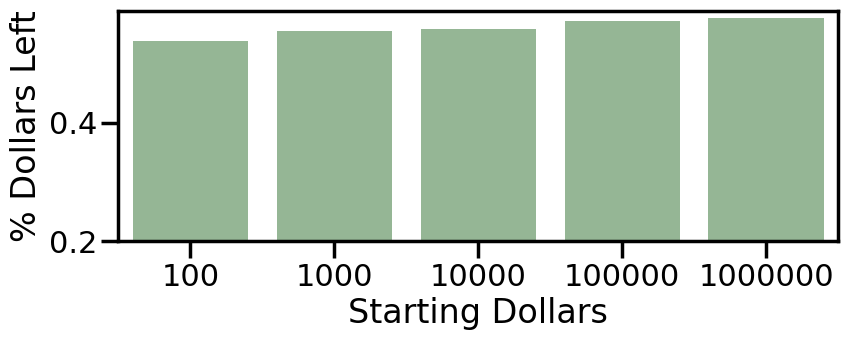

In [60]:

sns.set_context('poster')
fig, axs = plt.subplots(figsize=(9,4))
fig.tight_layout()

sns.barplot(df, x="Starting Dollars", y="% Dollars Left", 
                  color = "darkseagreen", ax=axs)

fig.tight_layout()
axs.set_ylim(0.2, 0.59)

 
fig.get_figure().savefig('figures/buy_seller_scaling_effects.pdf', bbox_inches='tight')
plt.show()



,vals1,init2,mean,std
0,40,100,0.13878,0.024413
1,400,1000,0.155049,0.023798
2,4000,10000,0.158902,0.027783
3,40000,100000,0.173,0.029003
4,400000,1000000,0.17786,0.021484
